Feature datatypes after conversion:
Event Description                                float64
Country                                            int64
Country ISO                                        int64
Admin 1                                            int64
Latitude                                         float64
Longitude                                        float64
Geo Precision                                      int64
Location of event                                  int64
Reported Perpetrator                               int64
Reported Perpetrator Name                          int64
Weapon Carried/Used                                int64
Type of education facility                         int64
Attacks on Schools                                 int64
Attacks on Universities                            int64
Military Occupation of Education facility          int64
Arson attack on education facility                 int64
Forced Entry into education facility               i

C:\Users\saumy\AppData\Roaming\Python\Python312\site-packages\xgboost\training.py:183: UserWarning: [14:55:08] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


✅ Accuracy: 0.9989154013015185

✅ Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.97      0.99        39
           1       1.00      1.00      1.00       883

    accuracy                           1.00       922
   macro avg       1.00      0.99      0.99       922
weighted avg       1.00      1.00      1.00       922


✅ Confusion Matrix:
 [[ 38   1]
 [  0 883]]


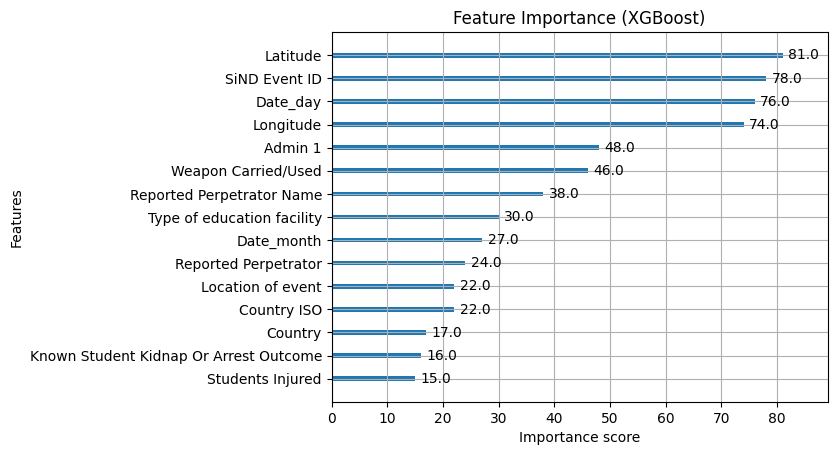

In [4]:
# ===============================
# 1. Import libraries
# ===============================
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import xgboost as xgb
import matplotlib.pyplot as plt

# ===============================
# 2. Load Dataset
# ===============================
df = pd.read_excel("2020-2025-education-in-danger-incident-data.xlsx")

# Define attack-related columns
attack_cols = [
    'Attacks on Schools', 'Attacks on Universities',
    'Military Occupation of Education facility',
    'Arson attack on education facility',
    'Forced Entry into education facility',
    'Damage/Destruction To Ed facility Event',
    'Attacks on Students and Teachers',
    'Educators Killed', 'Educators Injured', 'Educators Kidnapped', 'Educators Arrested',
    'Students Attacked in School', 'Students Killed', 'Students Injured',
    'Students Kidnapped', 'Students Arrested',
    'Sexual Violence Affecting School Age Children'
]


# ===============================
# 3. Create Target Column (Binary: Attack Happened)
# If incident_count > 0 => 1 else 0
# ===============================
df['attack_happened'] = df[attack_cols].sum(axis=1).apply(lambda x: 1 if x > 0 else 0)

# ===============================
# 4. Features (X) and Target (y)
# ===============================
X = df.drop(columns=['attack_happened'])   # features
y = df['attack_happened']                  # target

# ===============================
# 5. Encode Categorical Features
# ===============================
for col in X.select_dtypes(include=['object']).columns:
    le = LabelEncoder()
    X[col] = le.fit_transform(X[col].astype(str))

# Handle datetime columns
datetime_cols = X.select_dtypes(include=['datetime64[ns]']).columns
for col in datetime_cols:
    # Extract useful datetime features
    X[f'{col}_year'] = X[col].dt.year
    X[f'{col}_month'] = X[col].dt.month
    X[f'{col}_day'] = X[col].dt.day
    # Drop original datetime column
    X = X.drop(columns=[col])

# Convert all remaining features to appropriate types
for col in X.columns:
    if X[col].dtype == 'object':
        X[col] = X[col].astype('category')
    elif X[col].dtype not in ['int64', 'float64']:
        X[col] = X[col].astype('float64')

print("Feature datatypes after conversion:")
print(X.dtypes)

# ===============================
# 6. Train-Test Split
# ===============================
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# ===============================
# 7. Train XGBoost Classifier
# ===============================
model = xgb.XGBClassifier(
    objective='binary:logistic',
    eval_metric='logloss',
    use_label_encoder=False,
    random_state=42
)

model.fit(X_train, y_train)

# ===============================
# 8. Predictions
# ===============================
y_pred = model.predict(X_test)

# ===============================
# 9. Evaluation
# ===============================
print("✅ Accuracy:", accuracy_score(y_test, y_pred))
print("\n✅ Classification Report:\n", classification_report(y_test, y_pred))
print("\n✅ Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

# ===============================
# 10. Feature Importance Plot
# ===============================
xgb.plot_importance(model, max_num_features=15, importance_type='weight')
plt.title("Feature Importance (XGBoost)")
plt.show()
